#Imports

In [0]:
import math
import random
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#Create classes to hold point and body information

In [0]:
class point:
    def __init__(self, x,y,z):
        self.x = x
        self.y = y
        self.z = z

class body:
    def __init__(self, location, mass, velocity, name = ""): #L is angular velocity vector [Lx, Ly, Lz]
        self.location = location
        self.mass = mass
        self.velocity = velocity
        self.L = np.cross((self.location.x, self.location.y, self.location.z),(self.mass * self.velocity.x, self.mass * self.velocity.y, self.mass * self.velocity.z)).tolist()
        self.name = name

#Random body info generator
This is arbitrary at the moment based on what numbers just seem to create elliptical orbits with this model. 

Hopefully I can generalize in the future for E < 0 --> elliptical orbits

In [0]:
def random_posn():
  return point(random.randrange(-5e11, 5e11), random.randrange(-5e11, 5e11), random.randrange(-5e11, 5e11))

def random_vel():
  return point(random.randrange(-1e4, 1e4), random.randrange(-1e4, 1e4), random.randrange(-1e4, 1e4))

def random_mass():
  return random.random() * 1e26

def random_color():
  return (random.random(), random.random(), random.random())

#Model body behavior and collisions

In [0]:
def collisions(bodies, body_locations_hist):

  collision_indices = []

  for i in range(len(bodies)):
    for j in range(len(bodies)):
      r = math.sqrt((bodies[i].location.x - bodies[j].location.x)**2 + (bodies[i].location.y - bodies[j].location.y)**2 + (bodies[i].location.z - bodies[j].location.z)**2)
      if i != j and r < 2.5e10:
        collision_indices.append(i)   

  if collision_indices:
    
    colliders = []
    for index in reversed(collision_indices):
      colliders.append(bodies[index])
      body_locations_hist.pop(index)

    velx = (colliders[0].mass * colliders[0].velocity.x + colliders[1].mass * colliders[1].velocity.x) / (colliders[0].mass + colliders[1].mass)
    vely = (colliders[0].mass * colliders[0].velocity.y + colliders[1].mass * colliders[1].velocity.y) / (colliders[0].mass + colliders[1].mass)
    velz = (colliders[0].mass * colliders[0].velocity.z + colliders[1].mass * colliders[1].velocity.z) / (colliders[0].mass + colliders[1].mass)
    vel = point(velx, vely, velz)

    #create new body
    bodies.append(body(location = point(((colliders[0].location.x + colliders[1].location.x) / 2),((colliders[0].location.y + colliders[1].location.y) / 2), ((colliders[0].location.z + colliders[1].location.z) / 2)), mass = colliders[0].mass + colliders[1].mass, velocity = vel))
    body_locations_hist.append({"x":[], "y":[], "z":[], "name":bodies[-1].name})
    
    
    #remove colliders from bodies
    for collider in colliders:
      bodies.remove(collider)

In [0]:
def calculate_single_body_acceleration(bodies, body_index):
    G_const = 6.67408e-11 #m3 kg-1 s-2
    acceleration = point(0,0,0)
    target_body = bodies[body_index]
    for index, external_body in enumerate(bodies):
        if index != body_index:
            r = (target_body.location.x - external_body.location.x)**2 + (target_body.location.y - external_body.location.y)**2 + (target_body.location.z - external_body.location.z)**2
            r = math.sqrt(r)
            tmp = G_const * external_body.mass / r**3
            acceleration.x += tmp * (external_body.location.x - target_body.location.x)
            acceleration.y += tmp * (external_body.location.y - target_body.location.y)
            acceleration.z += tmp * (external_body.location.z - target_body.location.z)

    return acceleration

In [0]:
def compute_velocity(bodies, body_locations_hist, time_step = 1):
    
    collisions(bodies, body_locations_hist)

    for body_index, target_body in enumerate(bodies):
        acceleration = calculate_single_body_acceleration(bodies, body_index)

        target_body.velocity.x += acceleration.x * time_step
        target_body.velocity.y += acceleration.y * time_step
        target_body.velocity.z += acceleration.z * time_step 

In [0]:
def update_location(bodies, time_step = 1):
    for target_body in bodies:
        target_body.location.x += target_body.velocity.x * time_step
        target_body.location.y += target_body.velocity.y * time_step
        target_body.location.z += target_body.velocity.z * time_step

In [0]:
def compute_gravity_step(bodies, body_locations_hist, time_step = 1):
    compute_velocity(bodies, body_locations_hist, time_step = time_step)
    update_location(bodies, time_step = time_step)
    
    #update L
    for single_body in bodies:
      single_body.L = np.cross((single_body.location.x, single_body.location.y, single_body.location.z),(single_body.mass * single_body.velocity.x, single_body.mass * single_body.velocity.y, single_body.mass * single_body.velocity.z)).tolist()
      

#Simulation function

In [0]:
def run_simulation(bodies, names = None, time_step = 1, number_of_steps = 10000, report_freq = 100):

    #create output container for each body
    body_locations_hist = []

    for current_body in bodies:
        body_locations_hist.append({"x":[], "y":[], "z":[], "name":current_body.name})

    for i in range(1,number_of_steps):
        compute_gravity_step(bodies, body_locations_hist, time_step = 1000)            
        
        if i % report_freq == 0:
            for index, body_location in enumerate(body_locations_hist):
                body_location["x"].append(bodies[index].location.x)
                body_location["y"].append(bodies[index].location.y)           
                body_location["z"].append(bodies[index].location.z) 

    return body_locations_hist

#Plotting

In [0]:
def plot_output(bodies, L):
    print('body count: ', len(bodies))
    fig = plot.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    max_range = 0
    for current_body in bodies: 
        max_dim = max(max(current_body["x"]),max(current_body["y"]),max(current_body["z"]))
        if max_dim > max_range:
            max_range = max_dim
        ax.plot(current_body["x"], current_body["y"], current_body["z"], c = random_color(), label = current_body["name"])        
    
    ax.plot([0,L[0]],[0,L[1]],[0,L[2]],'r--')#plot L vector

    ax.set_xlim([-max_range,max_range])    
    ax.set_ylim([-max_range,max_range])
    ax.set_zlim([-max_range,max_range])

    ax.set_xlim([-5e11,5e11])    
    ax.set_ylim([-5e11,5e11])
    ax.set_zlim([-5e11,5e11])
    fig.suptitle('nbody orbit simulator')

    plot.show()

In [0]:
def plot_L_distribution(bodies):

    Ls = [single_body.L for single_body in bodies]
    Lx, Ly, Lz = map(list, zip(*Ls))

    fig, axs = plot.subplots(3, 1)
    fig.suptitle('distribution of Lx, Ly, and Lz')
    axs[0].hist(Lx)
    axs[1].hist(Ly)
    axs[2].hist(Lz)

    print('Standard dev. Lx:{0} Ly:{1} Lz:{2}'.format(np.std(Lx), np.std(Ly), np.std(Lz)))    


#Data

In [0]:
bodies = [body(location = point(0,0,0), mass = 2e30, velocity = point(0,0,0))] #initialize big central mass

N = 10 #for N-bodies in the simulation

for i in range(N):
  bodies.append(body(location = random_posn(), mass = random_mass(), velocity = random_vel()))

#Find angular momentum of all bodies


Standard dev. Lx:9.669624521823269e+40 Ly:1.3904421987726044e+41 Lz:1.3628467279738701e+41


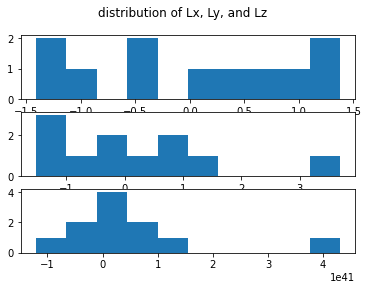

In [0]:
L_list = [single_body.L for single_body in bodies]
L_total = np.sum(L_list, axis=0)
plot_L_distribution(bodies)

#Simulate

body count:  8


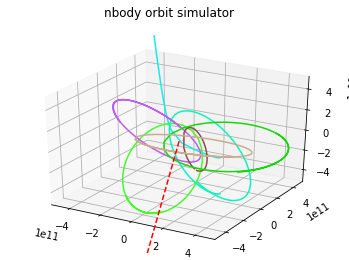

In [0]:
#simulate with collisions
motions = run_simulation(bodies, time_step = 1000, number_of_steps = 200000, report_freq = 2000)
plot_output(motions, L_total)


Standard dev. Lx:9.81025099686277e+40 Ly:1.6036628328000117e+41 Lz:1.4872349978031125e+41


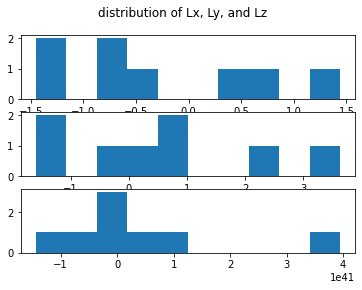

In [0]:
plot_L_distribution(bodies)

#Model limitations
* I'm trying to model gasses colliding with just...a relatively small number of discrete bodies. That probably only works so well. 
*   This uses the Euler method of numerical integration. It gets pretty inaccurate as you leave planetary scales...so that's why all the body values are so arbitrarily large. 
* If 2 bodies collide, their resultant body's history is plotted. Their 2 separate bodies' histories are not. 
* The collision condition is actually really stupid (r < 1e11) or something where a body's r can initially be between 0 and 5e11. This is because if I set the condition to be realistic (r < 1e7), I'd have to simulate a bajillion bodies in order for collisions to occur. And I don't have the time nor the computing power to do that. So instead of simulating more bodies, I just made the condition less realistic. Obviously, this is one of the drawbacks of modeling a gas with a small number of discrete bodies. 
*   Another reason the body values are the way they are is a result of that range of values for working well enough to, for the most part, yield elliptical orbits. Ideally, I'd have some sort of function to constrain the values the body can take so that it is elliptical (E < 0).  
*   You might get an error that looks something like...




> ---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-56-340df4a6003a> in <module>()
     1 motions = run_simulation(bodies, time_step = 5000, number_of_steps = 400000, report_freq = 6000)
      2 plot_output(motions, L_total)
3 frames

> --------------------------------------------------------------------------
<ipython-input-46-af6560a32bbc> in collisions(bodies, body_locations_hist)
     28     #remove old bodies
     29     for collider in colliders:
     30       bodies.remove(collider)
     31 
ValueError: list.remove(x): x not in list
> ------------------------------------------------------------------

* I haven't modified the collisions code to account for when more than 2 bodies are colliding. For the moment...just run the entire code again and you probably won't get this error again. 

#Credit where credit is due
This is built off of Ben Eagan's gravity.py, which can be found [here](https://gist.github.com/benrules2/a04a4d318625516877a0f3302331d407#file-gravity-py). My main contribution is generating random orbits, adding collisions, and tracking angular momentum.   